# Import Libraries

In [2]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import golden
from scipy.optimize import fminbound
from scipy.linalg import svd
from scipy.stats import trim_mean
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm

# Initialize Parameters

In [3]:
#### Grid Parameters
TE_array = np.arange(8, 512, 8) #ms units


#### Model parameters
c1 = 0.5
c2 = 0.5
T21 = 45
T22 = 200
T11 = 600
T12 = 1200

true_params = np.array([T11, T12, c1, c2, T21, T22])

#### Nullpoint Values
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

#### Process parameters
SNR_fixed = 100
num_iters = 10
rand_seed = 10
num_starts = 10

# Initialize Signal Functions

In [4]:
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def add_noise(data,SNR):
    sigma = 1/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

def get_func_bounds(function):
    f_name = function.__name__
    if f_name == "S_biX_4p":
        lower_bound = (-1,-1,1,1)
        upper_bound = (1,1,300,1000)
    elif f_name == "S_moX_2p":
        lower_bound = (-1,1)
        upper_bound = (1,1000)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(function):
    f_name = function.__name__
    if f_name == "S_biX_4p":
        params = ("d1","d2","T21","T22")
    elif f_name == "S_moX_2p":
        params = ("d","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def convert_fullOutput(output):
    
    if np.size(output)==3 or np.size(output)==5: #in the case of golden search methods
        TIvalue = output[0]
        minErr = output[1]
        numSteps = output[2]
    elif np.size(output)==4: #in the case of fminbound
        TIvalue = output[0]
        minErr = output[1]
        numSteps = output[3]

    outString = ("Opitmal TI value = {:.2f} :: Number of steps = {:.0f}".format(TIvalue,numSteps))

    return outString

# Initialize Process Functions

In [5]:
def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def estimate_NLLS(data, tdata, function):

    lb, ub = get_func_bounds(function)
    init_p = tuple(np.add(np.subtract(ub,lb)*np.random.uniform(0,1,np.size(lb)),lb))
    popt, pcov = curve_fit(function, tdata, data, bounds = (lb, ub), p0=init_p, max_nfev = 1500)
    popt = check_param_order(popt)
        
    return popt

def generate_noised_sigs(TI, tdata, SNR = SNR_fixed, params = true_params, iterations = num_iters, seed = rand_seed):
    noised_ensemble = np.zeros((iterations,np.size(tdata)))
    for iter in range(iterations):
        # np.random.seed(seed+iter)
        true_sig = S_biX_6p(tdata, TI, *params)
        noised_sig = add_noise(true_sig, SNR)
        noised_ensemble[iter,:] = noised_sig
    return noised_ensemble

def golden_omni(function, range, tol = 1.4901161193847656e-08, full_output = False, max_iter = 5000):
    #Finds the lambda which minimizes the total error of the NLLS estimates for a given data set
    #Implementation parallels the implementation of scipy.optimize.golden with default values as well

    goldRat = (5**(1/2)-1)/2

    lb = range[0]
    ub = range[1]

    input_list = []
    objective_list = []

    working_low = lb + (1-goldRat)*(ub - lb)
    working_high = lb + (goldRat)*(ub - lb)

    input_list.append(working_low)
    input_list.append(working_high)

    #Getting an initial measure of the parameters 
    obj_low = function(working_low)
    obj_high = function(working_high)

    objective_list.append(obj_low)
    objective_list.append(obj_high)

    iterations = 0

    regionThreshold = np.abs(working_high-working_low)
    while regionThreshold>tol:

        if obj_low > obj_high:
            lb = working_low
            obj_low = obj_high
            working_low = working_high
            working_high = lb + (goldRat)*(ub - lb)
            assert(working_low < working_high)

            input_list.append(working_high)

            obj_high = function(working_high)
            objective_list.append(obj_high)

        else:
            ub = working_high
            obj_high = obj_low
            working_high = working_low
            working_low = lb + (1-goldRat)*(ub - lb)
            assert(working_low < working_high)

            input_list.append(working_low)
            
            obj_low = function(working_low)
            objective_list.append(obj_low)

        regionThreshold = np.abs(working_high-working_low)
        iterations += 1
        if iterations > max_iter:
            break
    
    min_input = input_list[np.argmin(objective_list)]
    min_objective = np.min(objective_list)

    if full_output:
        return min_input, min_objective, np.size(input_list), input_list, objective_list
    else:
        return min_input, min_objective, np.size(input_list)

# Initialize Objective Functions

In [6]:
def calc_RSS_noise(TI, tdata, function, starts = num_starts):

    data = generate_noised_sigs(TI, tdata)

    iteration_RSS_values = np.zeros((data.shape[0],1))
    
    for i in range(data.shape[0]):
        noisey_signal = data[i,:]

        recreated_curves = np.zeros((starts,np.size(tdata)))
        recreated_curves_RSS = np.zeros((starts,1))
        recreated_popt = []                     #general to accomodate for different parameter sizes
        for start in range(starts):
            recreated_popt.append(estimate_NLLS(noisey_signal, tdata, function))
            recreated_curves[start,:] = function(tdata, *recreated_popt[start])
            recreated_curves_RSS[start] = np.sum((noisey_signal - recreated_curves[start,:])**2)

        iteration_RSS_values[i] = np.min(recreated_curves_RSS)

    return np.mean(iteration_RSS_values)


def calc_std(TI, tdata, function, param_select, starts = num_starts):

    data = generate_noised_sigs(TI, tdata)

    lb, ub = get_func_bounds(function)
    assert(param_select < np.size(lb))

    iteration_param_values = np.zeros((data.shape[0],np.size(lb)))
    
    for i in range(data.shape[0]):
        noisey_signal = data[i,:]

        recreated_curves = np.zeros((starts,np.size(tdata)))
        recreated_curves_RSS = np.zeros((starts,1))
        recreated_popt = []                     #general to accomodate for different parameter sizes
        for start in range(starts):
            recreated_popt.append(estimate_NLLS(noisey_signal, tdata, function))
            recreated_curves[start,:] = function(tdata, *recreated_popt[start])
            recreated_curves_RSS[start] = np.sum((noisey_signal - recreated_curves[start,:])**2)
            
        recreated_popt = np.array(recreated_popt)
        iteration_param_values[i,:] = recreated_popt[np.argmin(recreated_curves_RSS),:]

    std_values = -1*np.std(iteration_param_values, axis = 0) #have to invert to make it find a minimum

    return std_values[param_select]


# Running Optimization Functions

### GSS from Scipy

In [7]:
GSS_moX_RSS = golden(lambda TI: calc_RSS_noise(TI, TE_array, S_moX_2p), brack = (200,300), tol = 10**-1, full_output = True)

GSS_biX_std = golden(lambda TI: calc_std(TI, TE_array, S_biX_4p, 0), brack = (200,300), tol = 10**-1, full_output = True)

print("Scipy Golden Section Search Technique")
print("True Nullpoint 1 = {:.3f}".format(TI1star))
print("True Nullpoint 2 = {:.3f}".format(TI2star))
print("Estimated Nullpoint via RSS of moX results:" + convert_fullOutput(GSS_moX_RSS))
print("Estimated Nullpoint via std of biX results:" + convert_fullOutput(GSS_biX_std))

Scipy Golden Section Search Technique
True Nullpoint 1 = 415.888
True Nullpoint 2 = 831.777
Estimated Nullpoint via RSS of moX results:Opitmal TI value = 385.41 :: Number of steps = 11
Estimated Nullpoint via std of biX results:Opitmal TI value = 438.20 :: Number of steps = 10


### My GSS Implementation

Personal Golden Section Search Technique
True Nullpoint 1 = 415.888
True Nullpoint 2 = 831.777
Estimated Nullpoint via RSS of moX results:Opitmal TI value = 402.63 :: Number of steps = 12


c:\co\NIA\.grif_venv\lib\site-packages\numpy\core\fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


Text(0.5, 0.98, 'Highly Visualized GSS Algorithm \nError = -13.26 :: Relative Error = 3.19%\nSNR = 100')

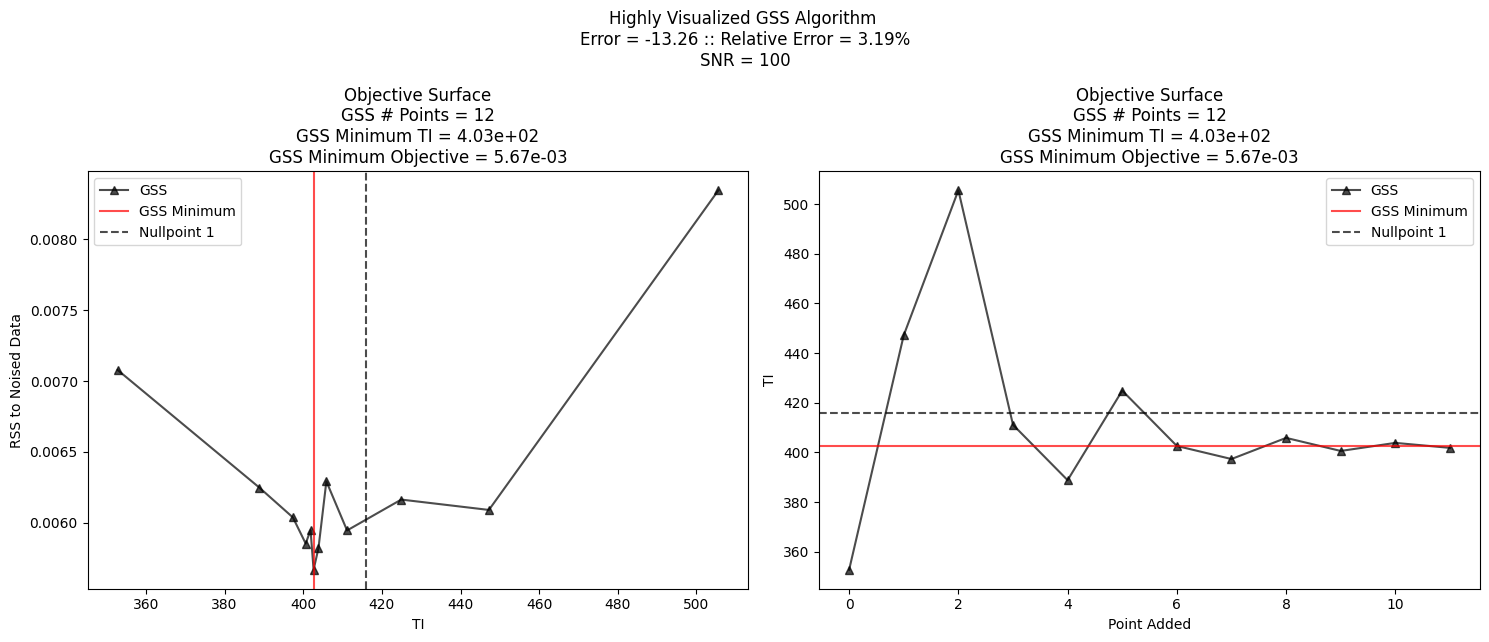

In [8]:
oGSS_moX_RSS = golden_omni(lambda TI: calc_RSS_noise(TI, TE_array, S_moX_2p), (200,600), tol = 1, full_output = True)

TI_GSS_list = oGSS_moX_RSS[-2]
obj_GSS_list = oGSS_moX_RSS[-1]
TI_GSS_list_sorted_index = np.argsort(TI_GSS_list)
TI_GSS_list_sorted = np.take_along_axis(np.array(TI_GSS_list), TI_GSS_list_sorted_index, axis=0)
obj_GSS_list_sorted = np.take_along_axis(np.array(obj_GSS_list), TI_GSS_list_sorted_index, axis=0)

print("Personal Golden Section Search Technique")
print("True Nullpoint 1 = {:.3f}".format(TI1star))
print("True Nullpoint 2 = {:.3f}".format(TI2star))
print("Estimated Nullpoint via RSS of moX results:" + convert_fullOutput(oGSS_moX_RSS))

fig, ax = plt.subplots(1,2,figsize=(15,6.5), tight_layout=True)
ax[0].plot(TI_GSS_list_sorted, obj_GSS_list_sorted, label = 'GSS', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[0].axvline(x=oGSS_moX_RSS[0], label = 'GSS Minimum', alpha = 0.7, color ='r', ls = '-')
ax[0].axvline(x=TI1star, label = 'Nullpoint 1', alpha = 0.7, color ='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('RSS to Noised Data')
ax[0].set_title('Objective Surface' + 
                '\nGSS # Points = ' + str(oGSS_moX_RSS[2]) +
                '\nGSS Minimum TI = {:.2e}'.format(oGSS_moX_RSS[0]) + 
                '\nGSS Minimum Objective = {:.2e}'.format(oGSS_moX_RSS[1]))
ax[0].legend()

ax[1].plot(TI_GSS_list, label = 'GSS', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[1].axhline(y=oGSS_moX_RSS[0], label = 'GSS Minimum', alpha = 0.7, color ='r', ls = '-')
ax[1].axhline(y=TI1star, label = 'Nullpoint 1', alpha = 0.7, color ='k', ls = '--')
ax[1].set_xlabel('Point Added')
ax[1].set_ylabel('TI')
ax[1].set_title('Objective Surface' + 
                '\nGSS # Points = ' + str(oGSS_moX_RSS[2]) +
                '\nGSS Minimum TI = {:.2e}'.format(oGSS_moX_RSS[0]) + 
                '\nGSS Minimum Objective = {:.2e}'.format(oGSS_moX_RSS[1]))
ax[1].legend()

fig.suptitle("Highly Visualized GSS Algorithm " + 
            "\nError = {:.2f} :: Relative Error = {:.2f}%".format(oGSS_moX_RSS[0] - TI1star,np.abs(TI1star-oGSS_moX_RSS[0])/TI1star*100) +
            "\nSNR = {:.0f}".format(SNR_fixed))

### FminBound Implementation

In [9]:
FMB_moX_RSS = fminbound(lambda TI: calc_RSS_noise(TI, TE_array, S_moX_2p), 200, 600, xtol = 10**-1, full_output = True, disp = 3)



print("Scipy Fminbound Technique - Brednt's Method - RSS")
print("True Nullpoint 1 = {:.3f}".format(TI1star))
print("True Nullpoint 2 = {:.3f}".format(TI2star))
print("Estimated Nullpoint via RSS of moX results:" + convert_fullOutput(FMB_moX_RSS))
print("     Error = {:.2f} :: Relative Error = {:.2f}%".format(FMB_moX_RSS[0] - TI1star,np.abs(TI1star-FMB_moX_RSS[0])/TI1star*100))


 
 Func-count     x          f(x)          Procedure
    1        352.786   0.00767769        initial
    2        447.214   0.00610051        golden
    3        505.573   0.00715345        golden
    4        436.724   0.00580793        parabolic
    5        404.662   0.00651793        golden
    6        430.109   0.00660251        parabolic
    7        436.757   0.00615177        parabolic
    8        434.197   0.00681923        golden
    9        435.759   0.00659707        golden
   10        436.355   0.00583568        golden
   11        436.583   0.00608557        golden
   12         436.67   0.00611619        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.1 )
Scipy Fminbound Technique - Brednt's Method - RSS
True Nullpoint 1 = 415.888
True Nullpoint 2 = 831.777
Estimated Nullpoint via RSS of moX results:Opitmal TI value = 436.72 :: Number of steps = 12
     Error = 20.84 :: Relative Error = 5.01%


In [10]:
print("\nScipy Fminbound Technique - Brednt's Method - Std Focus")
print("True Nullpoint 1 = {:.3f}".format(TI1star))
print("True Nullpoint 2 = {:.3f}".format(TI2star))
FMB_biX_std = []
for i in range(4):
    FMB_biX_std.append(fminbound(lambda TI: calc_std(TI, TE_array, S_biX_4p, i), 200, 600, xtol = 10**-1, full_output = True, disp = 3))
    print("Estimated Nullpoint via " + get_param_list(S_biX_4p)[i] + " std of biX results:" + convert_fullOutput(FMB_biX_std[i]))
    print("     Error = {:.2f} :: Relative Error = {:.2f}%".format(FMB_biX_std[i][0] - TI1star,np.abs(TI1star-FMB_biX_std[i][0])/TI1star*100))


Scipy Fminbound Technique - Brednt's Method - Std Focus
True Nullpoint 1 = 415.888
True Nullpoint 2 = 831.777
 
 Func-count     x          f(x)          Procedure
    1        352.786   -0.0666293        initial
    2        447.214    -0.110823        golden
    3        505.573    -0.357678        golden
    4        541.641    -0.255435        golden
    5        504.662    -0.325869        parabolic
    6        522.219    -0.326566        parabolic
    7        511.931    -0.538655        golden
    8        513.579    -0.309419        parabolic
    9        509.502    -0.117447        golden
   10        511.003    -0.279804        golden
   11         512.56    -0.431842        golden
   12        511.577    -0.126123        golden
   13        512.171    -0.315862        golden
   14        511.796   -0.0853593        golden
   15        512.023     -0.32364        golden
   16        511.879    -0.419833        golden
   17        511.966    -0.140135        golden

Optimizat

In [11]:
print("\nScipy Fminbound Technique - Brednt's Method - Std Focus")
print("True Nullpoint 1 = {:.3f}".format(TI1star))
print("True Nullpoint 2 = {:.3f}".format(TI2star))

FMB_biX_std = fminbound(lambda TI: calc_std(TI, TE_array, S_biX_4p, 2), 200, 600, xtol = 10**-1, full_output = True, disp = 3)
print("Estimated Nullpoint via T21 std of biX results:" + convert_fullOutput(FMB_biX_std))
print("     Error = {:.2f} :: Relative Error = {:.2f}%".format(FMB_biX_std[0] - TI1star,np.abs(TI1star-FMB_biX_std[0])/TI1star*100))


Scipy Fminbound Technique - Brednt's Method - Std Focus
True Nullpoint 1 = 415.888
True Nullpoint 2 = 831.777
 
 Func-count     x          f(x)          Procedure
    1        352.786     -37.1444        initial
    2        447.214     -79.3551        golden
    3        505.573     -61.6567        golden
    4        445.515     -83.0164        parabolic
    5        410.096     -80.1588        golden
    6        428.475      -76.083        parabolic
    7        439.006     -78.1146        golden
    8        443.029     -77.2326        golden
    9        444.565      -108.39        golden
   10        443.978     -88.4676        golden
   11        444.702     -67.1444        parabolic
   12        444.341     -62.9806        golden
   13         444.48     -65.0212        golden
   14        444.617     -85.3736        golden
   15        444.532     -87.6209        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =